In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import logit
from statsmodels.formula.api import ols
#모델 빌딩용 데이터, 테스트 데이터 쪼개기
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [2]:
general = pd.read_csv('general_final.csv')
#organizer = pd.read_csv('organizer_dollar.csv')
comments = pd.read_csv('comments_dollar.csv')
updates = pd.read_csv('updates_dollar.csv')
#donations = pd.read_csv('donations_dollar.csv')

In [ ]:
general #= general.drop(['Unnamed: 0'],axis=1)

### 변수찾기 1
- 48시간 내에 기부 건수 데이터를 가지고 있으니 활용할 방도가 있을까?
- 혹시 update가 48시간 내에 된 것들이 있다면, 그거랑 엮어보자.
- update로 인한 기부 증가의 효과를 확인할 수 있을지도 몰라!

In [ ]:
df1 = pd.merge(general, updates, on='chid', how='inner')
df1_1 = df1[['chid','scrape_date','num_recent_donations','created_at']]
df1_1['created_date'] = pd.to_datetime(df1_1['created_at'])#, utc= True).dt.strftime('%Y-%m-%d')
df1_3 = df1_1.drop(['created_at'], axis=1)
df1_4= df1_3[df1_3['num_recent_donations'] > 0]
df1_4['2days_later_updates'] = df1_4['created_date'] + pd.DateOffset(days=2)
df1_5 = df1_4[df1_4['scrape_date'] == df1_4['2days_later_updates']]
df1_5


최근 기부는 실패다.... 또르르
### 변수찾기 2
- 총 기부건수와 중복제거된 기부자수 데이터가 있으니 중복된 건수를 구할 수 있지 않을까?
- 중복 건수가 있다면, 그걸 종속변수로 써서 중복이 많이 된 케이스의 요인을 구할 수 있을지도..?!

In [ ]:
general['re_donation'] = general['total_donations'] - general['total_unique_donors']

In [ ]:
df2_1 = general[['chid','total_donations','total_unique_donors','re_donation']]

In [ ]:
df2_1[df2_1['re_donation'] < 0]

마이너스가 있네...? 이거 둘이 엮어서 쓰면 안되겠다.
### 변수찾기 3-1.
- 캠페인당 평균 기부금액을 종속변수에 넣어보자. 

In [3]:
df3_1 = general[['chid','created_date','category', 'story','total_photos', 'total_co_photos',
       'total_community_photos', 'total_comments', 'total_donations','total_updates','campaign_hearts','social_share_total','funds_raised_dollar', 'funds_target_dollar','char_age','dum_success','update_counts']]
df3_1['story']= df3_1['story'].astype(str)
df3_1['storylength'] = df3_1.story.str.len()
df3_1['commentlength'] = comments.comment.str.len()

In [4]:
#스토리 길이의 로그가 더 많을수록 성공할까? - 일단 로그변환
df3_1["logstorylength"]=np.log(df3_1["storylength"])
df3_1["logcomlength"]=np.log(df3_1["commentlength"])

In [24]:
df3_2 = df3_1.assign(average_amount = df3_1['funds_raised_dollar'] / df3_1['total_donations'])

# total_donations에 0과 null값이 있어서 infinity값 nan처리해주기!
df3_2['average_amount'].replace([np.inf, -np.inf], np.nan,inplace=True)


#df3_2 = df3_1[df3_1.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
#df3_1['average_amount'].isin((df3_1))#= df3_1['average_amount'].fillna(0)

In [25]:
# NULL값 확인
df3_2[df3_2['average_amount'].isnull() & df3_2['total_donations'].notnull()]

,chid,created_date,category,story,total_photos,total_co_photos,total_community_photos,total_comments,total_donations,total_updates,...,funds_raised_dollar,funds_target_dollar,char_age,dum_success,update_counts,storylength,commentlength,logstorylength,logcomlength,average_amount
1719,1721,2020-04-06,Accidents & Emergencies,I came to Japan two years ago on | a o/w ticke...,1.0,1.0,0.0,0.0,0.0,0.0,...,1000,NaN,211,0,0.0,1657,77.0,7.412764,4.343805,NaN
1781,1783,2020-03-04,Accidents & Emergencies,My husband and I live in the heavily hit Coron...,1.0,1.0,0.0,0.0,0.0,0.0,...,1000,NaN,244,0,0.0,377,69.0,5.932245,4.234107,NaN
1891,1893,2019-12-24,Accidents & Emergencies,I'm broke (but not a bum) and need a little bi...,1.0,1.0,0.0,0.0,0.0,0.0,...,3000,NaN,315,0,0.0,2945,398.0,7.987864,5.986452,NaN
2742,2744,2020-06-05,Accidents & Emergencies,"South Korean immigrantion is fining me for ""ov...",1.0,1.0,0.0,0.0,0.0,0.0,...,900,NaN,151,0,0.0,453,26.0,6.115892,3.258097,NaN


In [26]:
df3_2['average_amount'].describe()

count     3827.000000
mean       180.684048
std        485.098314
min          8.266725
25%         75.024115
50%        110.428571
75%        172.001622
max      14500.000000
Name: average_amount, dtype: float64

In [ ]:
df3_2[df3_2['average_amount'] == 14500]

In [ ]:
df3_2_trim = df3_2[df3_2['average_amount'] != 14500]

In [ ]:
sns.distplot(df3_2_trim['average_amount'])

In [ ]:
#plt.figure(figsize=(10,4))
#plt.xticks(rotation=45)
#sns.barplot(x='chid', y='average_amount', data=df3_1_trim)

In [ ]:
df3_2_trim['average_amount'].describe()

In [ ]:
res_success=ols('average_amount ~social_share_total +char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df3_2).fit()
res_success.summary()

In [ ]:
bins=[8.266725,75.016173,110.408048,171.927783]
np.digitize(df3_2['average_amount'],bins)

In [ ]:
df3_2['catraise']=np.digitize(df3_2['average_amount'],bins)
df3_2['catraise']

In [ ]:
res_success=ols('catraise ~social_share_total +char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df3_2).fit()
res_success.summary()

In [ ]:
df3_2["log_av_am"]=np.log(df3_2["average_amount"])

In [ ]:
res_success=ols('log_av_am ~social_share_total +char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df3_2).fit()
res_success.summary()

종속변수로 쓰니까 영 별로다.

### 변수찾기 3-2.
- 캠페인당 평균 기부금액을 독립변수로 사용해보자.

In [ ]:
res_success=logit('dum_success ~average_amount+social_share_total +char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df3_2).fit()
res_success.summary()

In [ ]:
train_df3_2, test_df3_2 = train_test_split(df3_2, test_size=0.2, random_state=1234)

In [ ]:
a=logit('dum_success ~average_amount+social_share_total +char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df3_2).fit()
a.summary()

In [ ]:
a_prob = a.predict(test_df3_2)
a_prediction = np.where(a_prob>0.5,1,0)

In [ ]:
confusion_matrix(test_df3_2['dum_success'], a_prediction)

In [ ]:
#accuracy
(443+30)/(443+30+31+277) * 100

종속변수로도 의미가 별로 없는 것 같다.

### 변수찾기 4.
- 캠페인의 1일 평균 기부자수를 종속변수에 넣어보자.
- 마찬가지로 1일 평균 기부금액은?
- 아마도 연식을 사용하면 1일 평균이 나올 것으로 판단된다.

1) 1일 평균 기부자수부터 보자!

In [5]:
# 먼저, 1일 평균 모금액구하고, inf는 Null처리
df4 = df3_1.assign(daily_average_donations = df3_1['total_donations'] / df3_1['char_age'])
df4.replace([np.inf, -np.inf], np.nan,inplace=True)

In [6]:
df4['daily_average_donations'].describe()

count    3830.000000
mean       12.161071
std        44.022476
min         0.000000
25%         1.528641
50%         3.494999
75%         8.047438
max      1355.750000
Name: daily_average_donations, dtype: float64

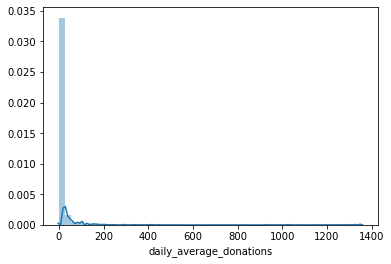

In [7]:
sns.distplot(df4['daily_average_donations'])

In [8]:
# df4의 describe 및 히스토그램을 보니, 치우친 분포이므로 로그취하기!
df4["log_daily_do"]=np.log(df4["daily_average_donations"])
df4

,chid,created_date,category,story,total_photos,total_co_photos,total_community_photos,total_comments,total_donations,total_updates,...,funds_target_dollar,char_age,dum_success,update_counts,storylength,commentlength,logstorylength,logcomlength,daily_average_donations,log_daily_do
0,1,2020-06-03,Funerals & Memorials,This is the official Chris Beaty GoFundMe crea...,3.0,1.0,2.0,74.0,1705.0,1.0,...,200000.0,153,0,1.0,1506,146.0,7.317212,4.983607,11.143791,2.410882
1,2,2020-06-21,"Medical, Illness & Healing",Shortly about Saha: | It is with a heavy heart...,1.0,1.0,0.0,0.0,602.0,0.0,...,226000.0,135,0,0.0,5152,18.0,8.547140,2.890372,4.459259,1.494983
2,3,2020-06-19,Education & Learning,Cost Breakdown | 100 Computers x approximately...,2.0,2.0,0.0,7.0,125.0,4.0,...,30000.0,138,0,4.0,6270,304.0,8.743532,5.717028,0.905797,-0.098940
3,4,2020-01-16,Accidents & Emergencies,I was caught within 7 miles of the Taal Volcan...,1.0,1.0,0.0,0.0,1.0,0.0,...,5000.0,292,0,0.0,402,38.0,5.996452,3.637586,0.003425,-5.676754
4,5,2020-11-02,Community & Neighbors,I have been on the board of the Center for Fam...,1.0,1.0,0.0,1.0,17.0,0.0,...,100000.0,2,0,0.0,1666,30.0,7.418181,3.401197,8.500000,2.140066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,3901,2020-07-24,"Medical, Illness & Healing","In late June, Matt Hansen was diagnosed with a...",1.0,1.0,0.0,17.0,673.0,0.0,...,15000.0,102,1,0.0,1399,65.0,7.243513,4.174387,6.598039,1.886773
3900,3902,2020-10-13,Funerals & Memorials,Scott Zurn was diagnosed with an aggressive fo...,1.0,1.0,0.0,27.0,356.0,0.0,...,20000.0,21,1,0.0,1423,238.0,7.260523,5.472271,16.952381,2.830408
3901,3903,2020-08-28,"Medical, Illness & Healing","First, and foremost, let��셲 talk about Sean. S...",2.0,2.0,0.0,41.0,562.0,3.0,...,50000.0,67,1,3.0,3135,24.0,8.050384,3.178054,8.388060,2.126809
3902,3904,2020-08-09,Funerals & Memorials,"On Monday August 3, 2020, Koorosh Yaghoubian (...",1.0,1.0,0.0,1.0,312.0,0.0,...,80000.0,86,0,0.0,617,219.0,6.424869,5.389072,3.627907,1.288656


In [9]:
# 사분위로 나눠서 해야겠다.
bins=[0.000000, 1.528641, 3.494999, 8.047438]
np.digitize(df4['daily_average_donations'],bins)

array([4, 3, 1, ..., 4, 3, 4], dtype=int64)

In [10]:
df4['catraise']=np.digitize(df4['daily_average_donations'],bins)
df4['catraise']

0       4
1       3
2       1
3       1
4       4
       ..
3899    3
3900    4
3901    4
3902    3
3903    4
Name: catraise, Length: 3904, dtype: int64

In [11]:
# 1. 그냥
res_success=ols('daily_average_donations ~social_share_total+char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df4).fit()
res_success.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     daily_average_donations   R-squared:                       0.380
Model:                                 OLS   Adj. R-squared:                  0.379
Method:                      Least Squares   F-statistic:                     289.6
Date:                     Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                             18:02:12   Log-Likelihood:                -18834.
No. Observations:                     3791   AIC:                         3.769e+04
Df Residuals:                         3782   BIC:                         3.774e+04
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.5308      5.841      2.830      0.005       5.079      27.983
social_share_total -2.294e-05      0.000     -0.207      0.836      -0.000       0.000
char_age              -0.1205      0.006    -19.557      0.000      -0.133      -0.108
logstorylength         0.6958      0.707      0.984      0.325      -0.690       2.081
total_photos          -0.1204      0.054     -2.235      0.025      -0.226      -0.015
update_counts         -0.3374      0.141     -2.386      0.017      -0.615      -0.060
total_comments         0.1020      0.012      8.708      0.000       0.079       0.125
logcomlength           0.1459      0.600      0.243      0.808      -1.030       1.321
campaign_hearts        0.0080      0.000     29.456      0.000       0.007       0.009
==============================================================================
Omnibus:                     7822.295   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35090712.003
Skew:                          17.067   Prob(JB):                         0.00
Kurtosis:                     473.092   Cond. No.                     7.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# 2. 로그 (안해도 됨)
#res_success=ols('log_daily_do ~social_share_total+char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df4).fit()
#res_success.summary()

In [13]:
# 3. 사분위
res_success=ols('catraise ~social_share_total +logstorylength+char_age+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df4).fit()
res_success.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               catraise   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     644.1
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:02:30   Log-Likelihood:                -4174.7
No. Observations:                3792   AIC:                             8367.
Df Residuals:                    3783   BIC:                             8424.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.0125      0.122     24.659      0.000       2.773       3.252
social_share_total  1.796e-05   2.32e-06      7.760      0.000    1.34e-05    2.25e-05
logstorylength         0.0316      0.015      2.137      0.033       0.003       0.061
char_age              -0.0076      0.000    -58.984      0.000      -0.008      -0.007
total_photos          -0.0062      0.001     -5.490      0.000      -0.008      -0.004
update_counts          0.0271      0.003      9.176      0.000       0.021       0.033
total_comments         0.0087      0.000     35.531      0.000       0.008       0.009
logcomlength           0.0100      0.013      0.795      0.427      -0.015       0.035
campaign_hearts    -5.042e-06   5.67e-06     -0.889      0.374   -1.62e-05    6.08e-06
==============================================================================
Omnibus:                       22.828   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.479
Skew:                          -0.172   Prob(JB):                     7.97e-06
Kurtosis:                       3.174   Cond. No.                     7.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2) 1일 평균 기부금액부터 보자!

In [14]:
# 먼저, 1일 평균 모금액구하고, inf는 Null처리
df4_1 = df3_1.assign(daily_average_amount = df3_1['funds_raised_dollar'] / df3_1['char_age'])
df4_1.replace([np.inf, -np.inf], np.nan,inplace=True)

In [15]:
df4_1['daily_average_amount'].describe()

count     3903.000000
mean      1006.098700
std       2811.638880
min          0.074074
25%        206.375837
50%        390.275000
75%        817.438974
max      96062.142857
Name: daily_average_amount, dtype: float64

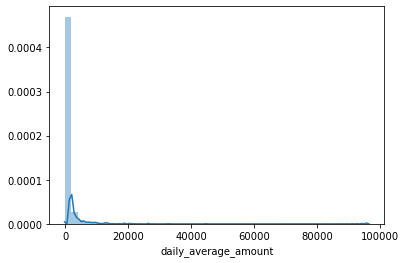

In [16]:
sns.distplot(df4_1['daily_average_amount'])

In [17]:
# df4의 describe 및 히스토그램을 보니, 치우친 분포이므로 로그취하기!
df4_1["log_daily_am"]=np.log(df4_1["daily_average_amount"])
df4_1

,chid,created_date,category,story,total_photos,total_co_photos,total_community_photos,total_comments,total_donations,total_updates,...,funds_target_dollar,char_age,dum_success,update_counts,storylength,commentlength,logstorylength,logcomlength,daily_average_amount,log_daily_am
0,1,2020-06-03,Funerals & Memorials,This is the official Chris Beaty GoFundMe crea...,3.0,1.0,2.0,74.0,1705.0,1.0,...,200000.0,153,0,1.0,1506,146.0,7.317212,4.983607,1144.333333,7.042578
1,2,2020-06-21,"Medical, Illness & Healing",Shortly about Saha: | It is with a heavy heart...,1.0,1.0,0.0,0.0,602.0,0.0,...,226000.0,135,0,0.0,5152,18.0,8.547140,2.890372,250.311111,5.522705
2,3,2020-06-19,Education & Learning,Cost Breakdown | 100 Computers x approximately...,2.0,2.0,0.0,7.0,125.0,4.0,...,30000.0,138,0,4.0,6270,304.0,8.743532,5.717028,100.326087,4.608426
3,4,2020-01-16,Accidents & Emergencies,I was caught within 7 miles of the Taal Volcan...,1.0,1.0,0.0,0.0,1.0,0.0,...,5000.0,292,0,0.0,402,38.0,5.996452,3.637586,0.085616,-2.457878
4,5,2020-11-02,Community & Neighbors,I have been on the board of the Center for Fam...,1.0,1.0,0.0,1.0,17.0,0.0,...,100000.0,2,0,0.0,1666,30.0,7.418181,3.401197,6975.000000,8.850088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,3901,2020-07-24,"Medical, Illness & Healing","In late June, Matt Hansen was diagnosed with a...",1.0,1.0,0.0,17.0,673.0,0.0,...,15000.0,102,1,0.0,1399,65.0,7.243513,4.174387,673.441176,6.512401
3900,3902,2020-10-13,Funerals & Memorials,Scott Zurn was diagnosed with an aggressive fo...,1.0,1.0,0.0,27.0,356.0,0.0,...,20000.0,21,1,0.0,1423,238.0,7.260523,5.472271,1968.095238,7.584821
3901,3903,2020-08-28,"Medical, Illness & Healing","First, and foremost, let��셲 talk about Sean. S...",2.0,2.0,0.0,41.0,562.0,3.0,...,50000.0,67,1,3.0,3135,24.0,8.050384,3.178054,883.656716,6.784069
3902,3904,2020-08-09,Funerals & Memorials,"On Monday August 3, 2020, Koorosh Yaghoubian (...",1.0,1.0,0.0,1.0,312.0,0.0,...,80000.0,86,0,0.0,617,219.0,6.424869,5.389072,683.337209,6.526988


In [18]:
# 사분위로 나눠서 해야겠다.
bins=[0.074074,206.375837,390.275000,817.438974]
np.digitize(df4_1['daily_average_amount'],bins)

array([4, 2, 1, ..., 4, 3, 4], dtype=int64)

In [19]:
df4_1['catraise']=np.digitize(df4_1['daily_average_amount'],bins)
df4_1['catraise']

0       4
1       2
2       1
3       1
4       4
       ..
3899    3
3900    4
3901    4
3902    3
3903    4
Name: catraise, Length: 3904, dtype: int64

In [20]:
# 1. 그냥
res_success=ols('daily_average_amount ~social_share_total+char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df4_1).fit()
res_success.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     daily_average_amount   R-squared:                       0.248
Model:                              OLS   Adj. R-squared:                  0.246
Method:                   Least Squares   F-statistic:                     155.6
Date:                  Sun, 29 Nov 2020   Prob (F-statistic):          4.21e-227
Time:                          18:06:24   Log-Likelihood:                -34993.
No. Observations:                  3791   AIC:                         7.000e+04
Df Residuals:                      3782   BIC:                         7.006e+04
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1566.3110    414.630      3.778      0.000     753.392    2379.230
social_share_total     0.0050      0.008      0.635      0.526      -0.010       0.020
char_age             -10.3725      0.437    -23.715      0.000     -11.230      -9.515
logstorylength        79.4308     50.171      1.583      0.113     -18.933     177.795
total_photos          -2.2515      3.823     -0.589      0.556      -9.747       5.244
update_counts        -28.4858     10.038     -2.838      0.005     -48.167      -8.805
total_comments         7.5892      0.831      9.131      0.000       5.960       9.219
logcomlength          26.3017     42.563      0.618      0.537     -57.147     109.750
campaign_hearts        0.2799      0.019     14.540      0.000       0.242       0.318
==============================================================================
Omnibus:                     7818.042   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         40473136.000
Skew:                          16.965   Prob(JB):                         0.00
Kurtosis:                     508.050   Cond. No.                     7.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# 2. 로그
res_success=ols('log_daily_am ~social_share_total+char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df4_1).fit()
res_success.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_daily_am   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     786.5
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:06:25   Log-Likelihood:                -4118.0
No. Observations:                3791   AIC:                             8254.
Df Residuals:                    3782   BIC:                             8310.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.8183      0.120     56.634      0.000       6.582       7.054
social_share_total  6.896e-06   2.28e-06      3.023      0.003    2.42e-06    1.14e-05
char_age              -0.0090      0.000    -70.803      0.000      -0.009      -0.009
logstorylength         0.0501      0.015      3.442      0.001       0.022       0.079
total_photos          -0.0039      0.001     -3.546      0.000      -0.006      -0.002
update_counts          0.0187      0.003      6.415      0.000       0.013       0.024
total_comments         0.0068      0.000     27.981      0.000       0.006       0.007
logcomlength           0.0011      0.012      0.090      0.928      -0.023       0.025
campaign_hearts     4.161e-05   5.59e-06      7.443      0.000    3.07e-05    5.26e-05
==============================================================================
Omnibus:                     1040.025   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20335.668
Skew:                          -0.811   Prob(JB):                         0.00
Kurtosis:                      14.230   Cond. No.                     7.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# 3. 사분위
res_success=ols('catraise ~social_share_total +logstorylength+char_age+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',df4_1).fit()
res_success.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               catraise   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     703.0
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:06:26   Log-Likelihood:                -4081.3
No. Observations:                3792   AIC:                             8181.
Df Residuals:                    3783   BIC:                             8237.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.2726      0.119     27.457      0.000       3.039       3.506
social_share_total   8.01e-06   2.26e-06      3.546      0.000    3.58e-06    1.24e-05
logstorylength         0.0468      0.014      3.247      0.001       0.019       0.075
char_age              -0.0087      0.000    -69.510      0.000      -0.009      -0.008
total_photos          -0.0042      0.001     -3.801      0.000      -0.006      -0.002
update_counts          0.0253      0.003      8.781      0.000       0.020       0.031
total_comments         0.0060      0.000     25.201      0.000       0.006       0.006
logcomlength          -0.0005      0.012     -0.040      0.968      -0.024       0.023
campaign_hearts     9.833e-06   5.53e-06      1.777      0.076   -1.02e-06    2.07e-05
==============================================================================
Omnibus:                       13.657   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.332
Skew:                          -0.092   Prob(JB):                     0.000469
Kurtosis:                       3.251   Cond. No.                     7.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# robust scale방법

##q = pd.DataFrame(q, columns=['odometer_reading'])

#robust import
##from sklearn.preprocessing import RobustScaler

# create a scaler object
##scaler = RobustScaler()
# fit and transform the data
##df_robust = pd.DataFrame(scaler.fit_transform(q), columns=q.columns)
##df_robust.describe()

### 코로나분석?

In [5]:
conditionlist = [
    (df3_1['created_date'] <= '2020-02-28') ,
    (df3_1['created_date'] >= '2020-03-01') & (df3_1['created_date'] <= '2020-06-30'),
    (df3_1['created_date'] >= '2020-07-01') & (df3_1['created_date'] <= '2020-11-04')]
choicelist = ['before_covid', 'during_covid', 'after_covid']
df3_1['period'] = np.select(conditionlist, choicelist, default='Not Specified')

In [7]:
bc = df3_1[df3_1['period'] == 'before_covid']
dc = df3_1[df3_1['period'] == 'during_covid']
ac = df3_1[df3_1['period'] == 'after_covid']

In [13]:
res_success=logit('dum_success ~social_share_total +char_age +logstorylength+total_photos+ update_counts +total_comments+logcomlength+campaign_hearts',bc).fit()
res_success.summary()

Optimization terminated successfully.
         Current function value: 0.659954
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            dum_success   No. Observations:                  752
Model:                          Logit   Df Residuals:                      743
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Dec 2020   Pseudo R-squ.:                 0.03400
Time:                        17:59:39   Log-Likelihood:                -496.29
converged:                       True   LL-Null:                       -513.75
Covariance Type:            nonrobust   LLR p-value:                 2.753e-05
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8108      1.072      0.756      0.450      -1.291       2.913
social_share_total  1.678e-05   1.94e-05      0.866      0.386   -2.12e-05    5.47e-05
char_age               0.0002      0.002      0.072      0.943      -0.005       0.005
logstorylength        -0.2764      0.096     -2.882      0.004      -0.464      -0.088
total_photos          -0.0103      0.012     -0.875      0.382      -0.033       0.013
update_counts         -0.0327      0.022     -1.489      0.136      -0.076       0.010
total_comments         0.0037      0.002      2.373      0.018       0.001       0.007
logcomlength           0.1727      0.083      2.081      0.037       0.010       0.335
campaign_hearts    -5.319e-05   8.63e-05     -0.616      0.538      -0.000       0.000
======================================================================================
"""

In [ ]:
# 전처리 후 story NULL 번호 보기
a = general[general['story'].isnull()]
a.chid#.tolist

### chid별 general['total_donations'] vs. donations.groupby('chid') 개수 상이
1.  대표값은 groupby로 하자.
     - 그 전에, total_donations의 row수(3904)에서 groupby한 후 row수(3900)가 줄어드는데, 뭐가 줄어들었는지 확인해보자.
     - 그리고 줄어든 row가 문제가 될 지 파악해보자.
     - chid: 1721, 1783, 1893, 2744가 donations에 없다. 그런데, general 'funds_raised'금액은 있네? 뭐야!!
     - 사이트 들어가봤더니, 'funds_raised'는 0이어야하고, 'funds_target'이 'funds_raised'에 있는 금액이어야 한다.
     - 그래서 general파일 바꿔주도록 하자.

In [ ]:
# general 파일 내용 수정하기
general.loc[general.chid==1721, 'funds_raised'] = 0
general.loc[general.chid==1783, 'funds_raised'] = 0
general.loc[general.chid==1893, 'funds_raised'] = 0
general.loc[general.chid==2744, 'funds_raised'] = 0
general.loc[general.chid==1721, 'funds_target'] = 1000
general.loc[general.chid==1783, 'funds_target'] = 1000
general.loc[general.chid==1893, 'funds_target'] = 3000
general.loc[general.chid==2744, 'funds_target'] = 900

In [ ]:
# csv로 내보내기
general.to_csv('general_new.csv', header= True ,index= False)

In [ ]:
# 줄어든 4개의 row 확인작업 
a = general#[['chid','total_donations']]
b = donations.groupby('chid').count()
b = b.reset_index()
c = b[['chid']]
d = a.merge(b, on='chid', how='left')
#d
d[d['donation_id'].isnull()]

## Currency별 모금액 알아보기
### 1. 기부자 기준

In [ ]:
#전체 기부자의 익명/기명 수 (False = 기명, True = 익명)
anonymous = donations['is_anonymous']
anonymous.value_counts()

In [ ]:
# 원하는 컬럼 추출
currency = donations[['chid','donation_id','currency','amount','is_anonymous','name']]
currency.head()

In [ ]:
# currency별 기부자의 비율
currency_counts = currency['currency'].value_counts()
donation_counts = currency['currency'].count()
currency_percentage = pd.DataFrame((round((currency_counts / donation_counts),3)*100))
currency_percentage = currency_percentage.reset_index()
currency_percentage.columns=['currency','percentage']
currency_percentage

In [ ]:
#currency별 기부자 수
cu_counts = pd.DataFrame(currency_counts)
cu_counts = cu_counts.reset_index()
cu_counts.columns = ['currency','counts']
cu_counts

In [ ]:
#currency별 기부금 총액
currency_amount = currency.groupby('currency').agg({'amount':'sum'})
currency_amount = currency_amount.reset_index()
currency_amount

In [ ]:
#currency별 기부자수, 기부자비율, 기부총액 합치기
currency_per = cu_counts.merge(currency_percentage, on='currency', how='left')
currency_all = currency_per.merge(currency_amount, on='currency', how='left')
currency_all

In [ ]:
# Currency별 기부자 비율 파이차트 그리기!!

from matplotlib import font_manager, rc
from matplotlib import style
'''
한글 라벨링에 필요
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')
'''
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'white']
labels = currency_all['currency']
ratio = currency_all['percentage']
# explode = (0.0, 0.0, 0.0, 0.0, 0.0)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임생성

pie = ax.pie(ratio, colors=colors, startangle=90, counterclock=False) 
    #, explode=explode, labels=labels,  autopct='%1.1f%%', shadow=True, textprops={'fontsize':13})

total = np.sum(ratio) ## 빈도수 합

threshold = 5 ## 상한선 비율
sum_pct = 0 ## 퍼센티지
 
bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일
 
## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-', color='b'),bbox=bbox_props,va='center') #퍼센트 선 속성변경
 
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(labels) - 1:
        sum_pct += float(f'{ratio[i]/total*100:.2f}')
        text = f'{ratio[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
    if ratio[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang2-0.5)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일 (A:각도 변경)
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(5*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=12)
    
plt.legend(pie[0],labels,loc='upper right', fontsize=11) ## 범례
plt.title('Percentage of Donors by Currency (counts)', fontsize=16)
plt.show()


### 2. 캠페인기준

In [ ]:
# currency별 캠페인 비율
currency_counts_g = general['currency'].value_counts()
donation_counts_g = general['currency'].count()
currency_percentage_g = pd.DataFrame((round((currency_counts_g / donation_counts_g),3)*100))
currency_percentage_g = currency_percentage_g.reset_index()
currency_percentage_g.columns=['currency','percentage']
currency_percentage_g

In [ ]:
#currency별 캠페인건 수
cu_counts_g = pd.DataFrame(currency_counts_g)
cu_counts_g = cu_counts_g.reset_index()
cu_counts_g.columns = ['currency','counts']
cu_counts_g

In [ ]:
#currency별 기부자수, 기부자비율, 기부총액 합치기
currency_all_g = cu_counts_g.merge(currency_percentage_g, on='currency', how='left')
currency_all_g

In [ ]:
# currency별 캠페인 수 비율 차트 그리기!!

from matplotlib import font_manager, rc
from matplotlib import style
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'white']
labels = currency_all_g['currency']
ratio = currency_all_g['percentage']
# explode = (0.0, 0.0, 0.0, 0.0, 0.0)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임생성

pie = ax.pie(ratio, colors=colors, startangle=90, counterclock=False) 
    #, explode=explode, labels=labels,  autopct='%1.1f%%', shadow=True, textprops={'fontsize':13})

total = np.sum(ratio) ## 빈도수 합

threshold = 3 ## 상한선 비율
sum_pct = 0 ## 퍼센티지
 
bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일
 
## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-', color='b'),bbox=bbox_props,va='center') #퍼센트 선 속성변경
spacing = 0.1
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(labels) - 1:
        sum_pct += float(f'{ratio[i]/total*100:.2f}')
        text = f'{ratio[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
    if ratio[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang2-0.5)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일 (A:각도 변경)
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(3*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=10)
    
plt.legend(pie[0],labels,loc='upper right', fontsize=12) ## 범례
plt.title('Percentage of Donations by Currency (counts)', fontsize=16)
plt.show()

## 통화별 성공 건수 비교

In [ ]:
# general과 donations 테이블 LEFT JOIN
donation_gen = donations.merge(general, on='chid', how='left')

In [ ]:
donation_gen.columns

In [ ]:
# 원하는 컬럼 추출
succ = donation_gen[['chid','donation_id','currency_x','amount','is_anonymous','name','success','dum_success']]
succ.head()

In [ ]:
#currency별로 성공건수 구하기
cu_succ = succ.groupby(['currency_x', 'success']).size().unstack(fill_value=0)
cu_succ = cu_succ.reset_index()
cu_succ.columns = ['currency','Fail','Success']
cu_succ[['currency','Success']].sort_values(by='Success', ascending = False)

### currency별 anonymous 기부 건수 & 금액의 차이 확인

In [ ]:
# currency별 기명, 무기명 기부 건수 컬럼 만들기
an_count = currency.groupby(['currency', 'is_anonymous']).size().unstack(fill_value=0) # anonymous 0과 1을 컬럼으로 빼기
an_count = pd.DataFrame(an_count)
an_count = an_count.reset_index()
an_count.columns = ['currency','identified','anonymous']
count_percentage = an_count.assign(identified_percentage = 
                                             round(an_count['identified']/
                                                   (an_count['identified']+an_count['anonymous']),2)*100,
                                             anonymous_percentage = 
                                             round(an_count['anonymous']/
                                                   (an_count['anonymous']+an_count['identified']),2)*100)
count_percentage

In [ ]:
# currency별 기명, 무기명 기부 건수 비율 그래프 그리기 (버전1)
count_percentage.index=count_percentage['currency'] #currency를 index로 만들기
count_bar = count_percentage[['identified_percentage','anonymous_percentage']]
count_bar.reset_index()
count_bar.columns = ['identified','anonymous']
count_bar = count_bar.sort_values(by=['identified'])
count_bar.plot(kind='barh', stacked = True)
plt.title('Percentage of Anonymous by Currency (counts)', fontsize=16)

In [ ]:
# currency별 기명, 무기명 기부 건수 비율 그래프 그리기 (버전2)
count_bar.plot(kind='barh')
plt.title('Percentage of Anonymous by Currency (counts)', fontsize=16)

In [ ]:
# currency별 기명, 무기명 기부 금액 컬럼 만들기
an_amount = currency.groupby(['currency', 'is_anonymous']).agg({'amount':'sum'}).unstack(fill_value=0)
an_amount.reset_index()
an_amount.columns=['identified','anonymous']
amount_percentage = an_amount.assign(identified_percentage = 
                                             round(an_amount['identified']/
                                                   (an_amount['identified']+an_amount['anonymous']),2)*100,
                                             anonymous_percentage = 
                                             round(an_amount['anonymous']/
                                                   (an_amount['anonymous']+an_amount['identified']),2)*100)

amount_percentage

In [ ]:
# currency별 기명, 무기명 기부 금액 비율 그래프 그리기 (버전1)
#amount_percentage.index=amount_percentage['currency'] #currency를 index로 만들기
amount_bar = amount_percentage[['identified_percentage','anonymous_percentage']]
amount_bar.reset_index()
amount_bar.columns = ['identified','anonymous']
amount_bar = amount_bar.sort_values(by=['identified'])
amount_bar.plot(kind='barh', stacked = True)
plt.title('Percentage of Anonymous by Currency (amount)', fontsize=16)

In [ ]:
# currency별 기명, 무기명 기부 금액 비율 그래프 그리기 (버전2)
amount_bar.plot(kind='barh')
plt.title('Percentage of Anonymous by Currency (amount)', fontsize=16)

In [ ]:
# currency별 기명, 무기명 기부 금액 범위 정하기 전 정보 알아보기 (describe)
amount_df = currency[['currency','amount']]
amount_desc = amount_df.describe()
amount_desc.loc['count'] = amount_desc.loc['count'].astype(int).astype(str)
amount_desc.iloc[1:] = amount_desc.iloc[1:].applymap('{:.1f}'.format)
print(amount_desc)
#amount_cu = currency.groupby(['currency']).size()
#amount_cu`

In [ ]:
## currency별 기명, 무기명 기부 금액 범위 정하기 전 정보 알아보기 (scatter)
sns.regplot(x=currency['amount'], 

           y=currency['donation_id'], 

           fit_reg=False) # no regression line

plt.title('Scatter Plot of iris by regplot()', fontsize=20)

plt.xlabel('Petal Length', fontsize=14)

plt.ylabel('Petal Width', fontsize=14)
#plt.xlim([0,50000])
plt.show()

In [ ]:
#currency별 금액대 기부건수 (index: currency)
amount_df['amount_cut']=pd.cut(amount_df.amount, bins=[0,10,20,30,40,50,60,70,80,90,100,400000], 
                               labels=['a','b','c','d','e','f','g','h','i','j','k']) # 금액대 나눠서 라벨링
amount_range_cu = amount_df.groupby(['currency','amount_cut']).size().unstack(fill_value=0) # 라벨링한 것 그룹별 합산
amount_range_cu.columns = ['1~10','11~20','21~30','31~40,','41~50','51~60','61~70','71~80','81~90','91~100','100~'] #컬럼명지정
amount_range_cu


In [ ]:
#currency별 금액대 기부건수 (index: range)
amount_df['amount_cut']=pd.cut(amount_df.amount, bins=[0,10,20,30,40,50,60,70,80,90,100,400000], 
                               labels=['1~10','11~20','21~30','31~40,','41~50','51~60','61~70','71~80','81~90','91~100','100~']) # 금액대 나눠서 라벨링
amount_range_ra = amount_df.groupby(['amount_cut','currency']).size().unstack(fill_value=0) # 라벨링한 것 그룹별 합산
amount_range_ra


In [ ]:
#dollar의 금액대 기부건수 그래프(index: currency)
dollar_range = amount_range_cu.loc[['dollar']]
dollar_range.plot(kind='bar')
plt.title('Number of donation by dollar amount range (currency)', fontsize=16)

In [ ]:
#dollar의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['dollar'].plot(kind='bar')
plt.title('Number of donation by dollar amount range (range)', fontsize=16)

In [ ]:
#euro의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['euro'].plot(kind='bar')
plt.title('Number of donation by euro amount range (range)', fontsize=16)

In [ ]:
#pound의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['pound'].plot(kind='bar')
plt.title('Number of donation by pound amount range (range)', fontsize=16)

In [ ]:
#krona의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['krona'].plot(kind='bar')
plt.title('Number of donation by krona amount range (range)', fontsize=16)

In [ ]:
#franc의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['franc'].plot(kind='bar')
plt.title('Number of donation by franc amount range (range)', fontsize=16)

In [ ]:
donation_chid = donations['amount'].value_counts().sort_values(ascending=False)
donation_chid.head(20)

In [ ]:
donation_amount_top20 = donation_chid.head(20)

In [ ]:
top20_donation_amount = donation_amount_top20.index

In [ ]:
for index, amount in enumerate(list(top20_donation_amount)):
    print ("TOP", index + 1, ":", amount)

In [ ]:
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

In [ ]:
donation_chid.iplot(kind='line', theme='white')